# Test Commands

In [1]:
import os
import torch
import torchaudio
import math, random
import librosa
from matplotlib import pyplot as plt
from torchaudio import transforms
from IPython.display import Audio

test_data = os.path.join('dataset', 'ambulance_data', 'ambulance54.wav')

metadata = torchaudio.info(test_data)
sig, sr = torchaudio.load(test_data)
sig.shape

torch.Size([2, 422912])

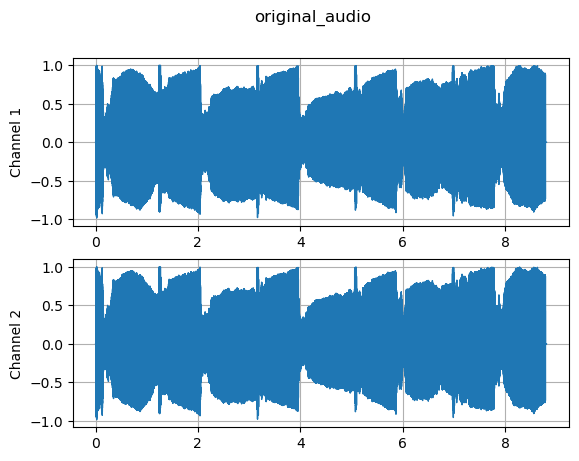

In [2]:
def plot_waveform(waveform, sample_rate, name):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(name)
    plt.show(block=False)
    
plot_waveform(sig, sr, "original_audio")

In [ ]:
duration = 3000
new_sr = 44100
shift_pct = 0.4
n_mels=64
n_fft=1024
hop_len=None
top_db = 80
channel = 2

aud = AudioUtil.open(test_data)
print(aud)
    
reaud = AudioUtil.resample(aud, sr)
rechan = AudioUtil.rechannel(reaud, channel)

dur_aud = AudioUtil.pad_trunc(rechan, duration)
shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

print(dur_aud)
print(aug_sgram)

plot_spectrogram(aug_sgram[0], new_sr)

In [ ]:
max_ms = 3000
new_sr = 44100
shift_pct = 0.4
n_mels=64
n_fft=1024
hop_len=None
top_db = 80

if (sig.shape[0] == 1):
      resig = torch.cat([sig, sig])

if (sr != new_sr):
    num_channels = resig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, new_sr)(resig)
    
    if (resig.shape[0] > 1):
                
      
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])
    
num_rows, sig_len = resig.shape
max_len = sr//1000 * max_ms

if (sig_len > max_len):
      # Truncate the signal to the given length
    sig = resig[:,:max_len]

elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
    pad_begin = torch.zeros((num_rows, pad_begin_len))
    pad_end = torch.zeros((num_rows, pad_end_len))

    sig = torch.cat((pad_begin, resig, pad_end), 1)

_, sig_len = sig.shape
shift_amt = int(random.random() * shift_pct * sig_len)
shifted_sig = sig.roll(shift_amt)

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
spec = transforms.MelSpectrogram(new_sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(shifted_sig)


    # Convert to decibels
spec = transforms.AmplitudeToDB(top_db=top_db)(spec)

#spec = torch.abs(spec)

print(spec.shape)
plot_waveform(sig,new_sr,'original audio')
plot_waveform(shifted_sig,new_sr, 'time shifted audio')

In [ ]:
Audio(sig.numpy(), rate=new_sr)

In [33]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
#plot_spectrogram(spec[0], new_sr)

In [ ]:
filename = 'sound_classification_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
external_model = pickle.load(open('sound_classification_model.sav', 'rb'))

In [ ]:
# ----------------------------
def inference (model, data):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
      # Get the input features and target labels, and put them on the GPU
      data_1 = data[0].clone().detach()
      data_2 = torch.Tensor(data[1])
      inputs = data_1.to(device)
      label = data_2.to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.float().mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      print(inputs)
      # Get predictions
      model.to(device)
      outputs = model(inputs.unsqueeze(0))

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
    
  #acc = correct_prediction/total_prediction
  print(prediction)

# Run inference on trained model with the validation set
inference(external_model, processed_audio)

# Manipulate LSAFEV dataset

In [ ]:
import pandas as pd

ambulance = pd.read_csv('D://Thesis//Emergency Priority//sound-recognition//dataset//Ambulance_final.csv')
ambulance['file_path'] = '//ambulance_data'
ambulance['classID'] = "1"
ambulance.head()

In [ ]:
road = pd.read_csv('D://Thesis//Emergency Priority//sound-recognition//dataset//Road_final.csv')
road['file_path'] = '//road_data'
road['classID'] = "0"
road.head()

In [ ]:
merge_data = pd.concat([ambulance, road])
merge_data

In [ ]:
merge_data.to_csv('D://Thesis//Emergency Priority//dataset//audio_dataset.csv', index=False)

# Import final dataset

In [3]:
import pandas as pd

# Read metadata file
metadata_file = 'D://Thesis//Emergency Priority//dataset//audio_dataset.csv'
df = pd.read_csv(metadata_file)
df.head()

# Take relevant columns
df = df[['filename', 'file_path', 'classID']]
df

,filename,file_path,classID
0,ambulance142.wav,//ambulance_data,1
1,ambulance449.wav,//ambulance_data,1
2,ambulance888.wav,//ambulance_data,1
3,ambulance474.wav,//ambulance_data,1
4,ambulance305.wav,//ambulance_data,1
...,...,...,...
1829,road638.wav,//road_data,0
1830,road323.wav,//road_data,0
1831,road233.wav,//road_data,0
1832,road244.wav,//road_data,0


# Create Audio Manipulation

In [4]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

# Create Dataset loader

In [5]:
from torch.utils.data import  Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class AudioDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 3000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx,'file_path'] + '//' + self.df.loc[idx,'filename']
    #self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [6]:
from torch.utils.data import random_split

data_path = 'D://Thesis//Emergency Priority//sound-recognition//dataset'
data_set = AudioDS(df, data_path)


# Random split of 80:20 between training and validation
num_items = len(data_set)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(data_set, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)

# Create Model

In [7]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cuda', index=0)

# Train Model

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    
  print("--------------------- Training Start ----------------------")
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model = model.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        if i % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=6
training(model, train_dl, num_epochs)

In [ ]:
# Save the Model
#torch.save(model.state_dict(), 'siren_detection_model.pth')

In [8]:
trained_model = AudioClassifier()
trained_model.load_state_dict(torch.load('siren_detection_model.pth'))
trained_model = trained_model.to(device)

# Inference

In [ ]:
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      # Get predictions
      print(inputs.shape)
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
    
      '''for i in prediction:
            if i == 1:
                print('Ambulance Detected')
            else:
                print('No Ambulance')'''
      #print('Predicted:', prediction)
      #print('Actual:', labels)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(model, val_dl)

# Use Pyaudio for microphone input

In [ ]:
import pyaudio

p = pyaudio.PyAudio()
device_count = p.get_device_count()
for i in range(device_count):
    print(p.get_device_info_by_index(i))

p.terminate()

In [ ]:
CHANNELS = 2
FRAME_RATE =44100
RECORD_SECONDS = 3
AUDIO_FORMAT = pyaudio.paInt16
SAMPLE_SIZE = 2

def record_microphone(chunk=1024):
    iter = 0
    p = pyaudio.PyAudio()

    stream = p.open(format=AUDIO_FORMAT,
                    channels=CHANNELS,
                    rate=FRAME_RATE,
                    input=True,
                    input_device_index=1,
                    frames_per_buffer=chunk)
    
    frames = []
    while True:
        print('Recording..')
        data = stream.read(chunk)
        frames.append(data)
        iter += 1

        if len(frames) >= (FRAME_RATE * RECORD_SECONDS) / chunk:
            frame = numpy.frombuffer(frames, dtype=numpy.int16)
            frame = numpy.stack((frame[::2], frame[1::2]), axis=0) 
            frames = []
            break

    stream.stop_stream()
    stream.close()
    p.terminate()
    print(frame.shape)
    print('End Recording')
        
record_microphone()
#frame = recording.get()
#print(frame)

# Soundcard for input

In [28]:
import soundcard as sc
import time

mics = sc.all_microphones()
speaker = sc.get_speaker('Realtek')
usb_microphone = sc.get_microphone('USB')
print(usb_microphone)

<Microphone Microphone (USB Condenser Microphone) (1 channels)>


In [10]:
with usb_microphone.recorder(samplerate=44100) as mic, \
            speaker.player(samplerate=44100) as sp:
    data = mic.record(numframes=None)
    sp.play(data)

## Record From Microphone

In [11]:
import numpy
auds = []
win = 3
count = 0

duration = 3000
new_sr = 44100
shift_pct = 0.4
n_mels=64
n_fft=1024
hop_len=None
top_db = 80
channel = 2
sr = 44100

def open(audio_file, sr):
    return (audio_file, sr)

with usb_microphone.recorder(samplerate=44100) as mic, \
            speaker.player(samplerate=44100) as sp:
    print("Recording...")
    data = mic.record(numframes=529200)
    print("Done...Stop your sound so you can hear playback")
    
    time.sleep(1)
    #sp.play(data)
    #sig_mic = torch.tensor(data)
    waves = []
    #print(len(sig_mic[1]))
    for i in range(0, len(data),win * sr):
        y = data[count:win * sr + count]
        count += 1
        
        tensor_mic = torch.tensor(y).reshape((2, -1))

        sig_mic = tensor_mic.float()
        aud = open(sig_mic, sr)
            #sig_mic = sig_mic.cat(sr)
            #print(aud)

        reaud = AudioUtil.resample(aud, new_sr)
        rechan = AudioUtil.rechannel(reaud, channel)
        dur_aud = AudioUtil.pad_trunc(rechan, duration)
        shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        
        waves.append(aug_sgram.numpy())
    
    #sig_mic = torch.tensor(numpy.array(auds))
    
    stacked = numpy.stack(waves)
    batch = torch.tensor(stacked)
        
    #print(batch[0][0])
    for i in range(4):
        plot_spectrogram(aug_sgram[0], sr)


Recording...
Done...Stop your sound so you can hear playback


NameError: name 'plot_spectrogram' is not defined

In [59]:
import numpy
auds = []
win = 3
count = 0
from time import sleep

def open(audio_file, sr):
    return (audio_file, sr)

def detect_ambulance():

    duration = 3000
    new_sr = 44100
    shift_pct = 0.4
    n_mels=64
    n_fft=1024
    hop_len=None
    top_db = 80
    channel = 2
    sr = 44100


    with usb_microphone.recorder(samplerate=44100) as mic, \
                speaker.player(samplerate=44100) as sp:
        batch = 0
        frames = []
        waves = []
        print("Recording...")
        while not record_state.empty():
            data = mic.record(numframes=1024)
            #print(data.shape)
            frames.append(data)

            if batch >= 2:
                stacked = numpy.stack(waves)
                final_audio = torch.tensor(stacked)

                print('----Batch Sent----')
                
                batch_q.put(final_audio)         

                batch = 0
                waves = []
                
                
            if len(frames) > (new_sr * 3) / 1024:
                #print('frames: ', len(frames))
                aud = numpy.stack(frames)
                # merge to 2D 3sec windows
                aud = aud.transpose(2,0,1).reshape(2,-1)
                
                # convert to tensor
                tensor_mic = torch.tensor(aud)
                tensor_mic = tensor_mic.float()

                aud = open(tensor_mic, sr)

                reaud = AudioUtil.resample(aud, new_sr)
                rechan = AudioUtil.rechannel(reaud, channel)

                dur_aud = AudioUtil.pad_trunc(rechan, duration)
                shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
                sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
                #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

                waves.append(sgram.numpy())

                frames = []
                batch += 1
        print('Record Stopped')
    
#detection = detect_ambulance()

In [102]:
def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)
    # Set Connecting Client ID
    client = mqtt_client.Client(client_id)
    # client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client


def publish(client, text, tp):
    msg = f"{text}"
    result = client.publish(tp, msg)
    # result: [0, 1]
    status = result[0]


def cons_inference(model, client):
    sleep(7)
    while not batch_q.empty():
        print('Fetching')
        data = batch_q.get()
        is_ambulance = False
        #for i in range(2):
            #plot_spectrogram(data[i][0], 44100)

          # Disable gradient updates
        with torch.no_grad():
              # Get the input features and target labels, and put them on the GPU
            inputs = data.to(device)

              # Normalize the inputs
            inputs_m, inputs_s = inputs.float().mean(), inputs.std()
            input = (inputs - inputs_m) / inputs_s

            outputs = model(input)

              # Get the predicted class with the highest score
            probs = torch.nn.functional.softmax(outputs, dim=1)
            conf, prediction = torch.max(probs,1)
            
            common_conf = (conf[0] + conf[1])/2
            
            print(prediction[0])
            print(prediction[1])
            print(common_conf)
            
            if prediction[0] == 1 and prediction[1] == 1 and common_conf > 0.48:
                is_ambulance = True
            elif prediction[0] == 1 or prediction[1] == 1:
                print(conf)
                if common_conf > 0.70:
                    is_ambulance = True
            
            if is_ambulance:
                print('Ambulance Detected', common_conf)
                publish(client,1,topic)
            else:
                print('No Ambulance')
                publish(client,0,topic)
            
            sleep(6.1)

Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4725, device='cuda:0')
tensor([0.4232, 0.5217], device='cuda:0')
No Ambulance


## Stream Microphone

In [106]:
from queue import Queue
from threading import Thread
from paho.mqtt import client as mqtt_client

broker = '192.168.1.1'
port = 1883
topic = "em/sound"
client_id = f'python-mqtt-{random.randint(0, 1000)}'

client = connect_mqtt()

record_state = Queue()
batch_q = Queue()

record_state.put(True)

record = Thread(target=detect_ambulance)
record.start()
sound_classification = Thread(target=cons_inference, args=(trained_model,client,))
sound_classification.start()

Recording...
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4541, device='cuda:0')
tensor([0.6606, 0.2476], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4449, device='cuda:0')
tensor([0.3196, 0.5703], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.6197, device='cuda:0')
tensor([0.3877, 0.8516], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4843, device='cuda:0')
Ambulance Detected tensor(0.4843, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.7800, device='cuda:0')
tensor([0.9092, 0.6508], device='cuda:0')
Ambulance Detected tensor(0.7800, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4843, device='cud

----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.7158, device='cuda:0')
tensor([0.5727, 0.8589], device='cuda:0')
Ambulance Detected tensor(0.7158, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.5729, device='cuda:0')
tensor([0.3543, 0.7915], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4876, device='cuda:0')
Ambulance Detected tensor(0.4876, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.7437, device='cuda:0')
tensor([0.6250, 0.8625], device='cuda:0')
Ambulance Detected tensor(0.7437, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.7447, device='cuda:0')
tensor([0.8939, 0.5955], device='cuda:0')
Ambulance Detected tensor(0.7447, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device=

Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.5073, device='cuda:0')
tensor([0.3516, 0.6631], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5741, device='cuda:0')
tensor([0.5601, 0.5882], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4885, device='cuda:0')
Ambulance Detected tensor(0.4885, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4754, device='cuda:0')
tensor([0.5550, 0.3958], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4881, device='cuda:0')
Ambulance Detected tensor(0.4881, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4868, device='cuda:0')
Ambulance Detected tensor(0.4868, device='cuda:0')
----Batch Sent---

----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5454, device='cuda:0')
tensor([0.6642, 0.4265], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.5395, device='cuda:0')
tensor([0.3756, 0.7035], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.8414, device='cuda:0')
tensor([0.8301, 0.8526], device='cuda:0')
Ambulance Detected tensor(0.8414, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.7759, device='cuda:0')
tensor([0.8281, 0.7237], device='cuda:0')
Ambulance Detected tensor(0.7759, device='cuda:0')
----Batch Sent----
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.5889, device='cuda:0')
tensor([0.4430, 0.7348], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tenso

----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4880, device='cuda:0')
Ambulance Detected tensor(0.4880, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4894, device='cuda:0')
Ambulance Detected tensor(0.4894, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.6720, device='cuda:0')
tensor([0.5688, 0.7752], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.7013, device='cuda:0')
tensor([0.8372, 0.5655], device='cuda:0')
Ambulance Detected tensor(0.7013, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4784, device='cuda:0')
tensor([0.4798, 0.4771], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4965, device='cuda:0')
tensor([0.2

----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5922, device='cuda:0')
tensor([0.7388, 0.4456], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4897, device='cuda:0')
Ambulance Detected tensor(0.4897, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4880, device='cuda:0')
Ambulance Detected tensor(0.4880, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5095, device='cuda:0')
tensor([0.6054, 0.4136], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4815, device='cuda:0')
Ambulance Detected tensor(0.4815, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.6130, device='cuda:0')
tensor([0.7194, 0.5065], device='cuda:0')
No Ambulanc

----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4898, device='cuda:0')
Ambulance Detected tensor(0.4898, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.5075, device='cuda:0')
tensor([0.4341, 0.5810], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4746, device='cuda:0')
tensor([0.6514, 0.2979], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.7169, device='cuda:0')
tensor([0.8021, 0.6317], device='cuda:0')
Ambulance Detected tensor(0.7169, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4890, device='cuda:0')
Ambulance Detected tensor(0.4890, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4802, device='cuda:0')
Ambulance D

Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.6976, device='cuda:0')
tensor([0.7630, 0.6322], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5668, device='cuda:0')
tensor([0.6312, 0.5024], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.6117, device='cuda:0')
tensor([0.4935, 0.7299], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5841, device='cuda:0')
tensor([0.7133, 0.4549], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4822, device='cuda:0')
Ambulance Detected tensor(0.4822, device='cuda:0')
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.6025, device='cuda:0')
tensor([0.5001, 0.7049], device='cuda:0')
No Ambulance
----Batch

----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5614, device='cuda:0')
tensor([0.6741, 0.4487], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.6108, device='cuda:0')
tensor([0.7401, 0.4815], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4992, device='cuda:0')
tensor([0.3499, 0.6484], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5294, device='cuda:0')
tensor([0.6937, 0.3652], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4883, device='cuda:0')
Ambulance Detected tensor(0.4883, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4888, device='cuda:0')
Ambulance Detected tensor(0.4888, device='cud

Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.6368, device='cuda:0')
tensor([0.7890, 0.4846], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5563, device='cuda:0')
tensor([0.7421, 0.3705], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4401, device='cuda:0')
tensor([0.3609, 0.5193], device='cuda:0')
No Ambulance
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4894, device='cuda:0')
Ambulance Detected tensor(0.4894, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4882, device='cuda:0')
Ambulance Detected tensor(0.4882, device='cuda:0')
----Batch Sent----
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4833, device='cuda:0')
Ambulance Detected tensor(0.4833, device='cuda:0')
----Batch Sent---

In [107]:
if not record_state.empty():
    record_state.get()

Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4653, device='cuda:0')
tensor([0.5621, 0.3686], device='cuda:0')
No Ambulance
Record Stopped
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4739, device='cuda:0')
tensor([0.4360, 0.5117], device='cuda:0')
No Ambulance
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.5436, device='cuda:0')
tensor([0.7065, 0.3806], device='cuda:0')
No Ambulance
Fetching
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.6673, device='cuda:0')
tensor([0.5913, 0.7433], device='cuda:0')
No Ambulance
Fetching
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0.4808, device='cuda:0')
Ambulance Detected tensor(0.4808, device='cuda:0')
Fetching
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.6749, device='cuda:0')
tensor([0.8177, 0.5322], device='cuda:0')
No Ambulance


In [123]:
#flush data

if not batch_q.empty():
    cons_inference(trained_model)

batch_q.empty()

Fetching
Ambulance Detected tensor([0.8371, 0.5422], device='cuda:0')
No Ambulance
Fetching
No Ambulance
No Ambulance


True

In [22]:
if not batch_q.empty():
    word = batch_q.get()
    inference(trained_model, word)